In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from datetime import datetime, timedelta


def df_to_X_y2(df,window_size=5):
    df_as_numpy=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_numpy)-window_size):
        row=[a for a in df_as_numpy[i:i+window_size]]
        X.append(row)
        label=df_as_numpy[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

def plot_predictions3(model,X_sample,y):
    predictions=model.predict(X_sample).flatten()[1:].copy()
    df= pd.DataFrame(data={'Predictions':predictions,'Actuals':y[:-1]}).copy()
    plt.plot(df['Predictions']*oleo_std+oleo_mean,label='p')
    plt.plot(df['Actuals']*oleo_std+oleo_mean,label='a')
    plt.legend()
    plt.grid()
    return df, mse(y[:-1],predictions)

def fix_randoness():
    seed_value=42
    # Seed value
    # Apparently you may use different seed values at each stage

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    # for later versions: 
    # tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    # for later versions:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [2]:
df=pd.read_csv('dados_unidos2.txt',sep='\t',decimal=',',encoding='UTF-8')
trocar_colunas={'Período': 'Data', 'Poço ANP':'Poco', 'Petróleo Equivalente (boe/d)':'boed',
           'Óleo (m3/d)':'oleo', 'Gás Natural (mil m3/d)':'gas', 'Água (m3/d)':'agua', 'Dias':'dias',
           'Potencial':'potencial'}
df=df.rename(columns=trocar_colunas)
df['BSW']=df['agua']/(df['agua']+df['oleo']+0.00000001)
#print(df.head)
#df=df[df.agua>0.1]
dfs_pocos=[]
for i in df.Poco.unique():
    dfs_pocos.append([i,df[df.Poco==i]])
dfs_pocos


[['7-RO-46HP-RJS',
             Data     Campo           Poco      boed     oleo     gas     agua  \
  0    2009-02-01  RONCADOR  7-RO-46HP-RJS  19768.52  2882.84  260.10     2.88   
  1    2009-03-01  RONCADOR  7-RO-46HP-RJS  19283.17  2820.46  245.32     2.82   
  2    2009-04-01  RONCADOR  7-RO-46HP-RJS  19129.89  2804.91  236.50     2.80   
  3    2009-05-01  RONCADOR  7-RO-46HP-RJS  18759.25  2799.78  182.71     2.80   
  4    2009-06-01  RONCADOR  7-RO-46HP-RJS  18617.98  2741.20  218.83     2.74   
  ..          ...       ...            ...       ...      ...     ...      ...   
  172  2023-06-01  RONCADOR  7-RO-46HP-RJS   8440.01  1279.62   62.24  1426.15   
  173  2023-07-01  RONCADOR  7-RO-46HP-RJS   8965.28  1355.36   70.01  1687.53   
  174  2023-08-01  RONCADOR  7-RO-46HP-RJS   7945.12  1191.41   71.77  1505.19   
  175  2023-09-01  RONCADOR  7-RO-46HP-RJS   8387.89  1251.29   82.28  1343.15   
  176  2023-10-01  RONCADOR  7-RO-46HP-RJS   8248.01  1230.95   80.38  1276.60 

In [3]:
df.Poco.unique()

array(['7-RO-46HP-RJS', '7-RO-50HPA-RJS', '7-RO-60HP-RJS',
       '7-RO-62HP-RJS', '7-RO-63HA-RJS', '7-RO-72HPB-RJS',
       '7-RO-74HP-RJS', '8-RO-58HP-RJS', '7-RO-135H-RJS'], dtype=object)

In [4]:
eficiencias_escolha=[.2,.4,.6,.7,.8,.9]

#eficiencias_escolha=[.7,.8,.9]
#eficiencias_escolha=[.8]
list_previsao=[]
list_erros=[]
list_prev_poco={}
for j in dfs_pocos[:]:
    for ef_escolhida in eficiencias_escolha:
        df = j[1]
        print(df.Poco.unique())
        print(ef_escolhida)
        df['Data']=pd.to_datetime(df.Data, format='%Y-%m-%d')
        df.index=pd.to_datetime(df.Data, format='%Y-%m-%d')
        #data_inicial=0#df.Data.min()

        # Criar colunas de produção bruta e de óleo acumuladas em volume para normalizar o tempo
        df['mes'] = df.Data.apply(lambda x: x.days_in_month)
        df['tn']  = df['oleo']*df['mes']/1000000
        df['tn_2']= (df['oleo']+df['agua'])*df['mes']/1000000
        df['tn']  = df['tn'].cumsum()
        df['tn_2']= df['tn_2'].cumsum()
        # Calcular o BSW
        df['BSW']=df['agua']/(df['agua']+df['oleo']+0.0001)
        #separando o banco de dados para teste
        df_prev=df[-12:].copy()
        #separando o vector de eficiências do teste
        vector_ef=df_prev['ef']
        vector_dias_mes=df_prev['mes']
        #retirando valores de produção nulos
        df=df[df.oleo>0]
        # Achar o último bsw para estimar a bruta
        # separando os dados que serão utilizados para treino e validação
        df=df[:-12]
        bsw_median=df[-7:].BSW.median()
        #print('Tamanho antes do filtro:  ' +str(len(df)))
        # eficiência de corte
        #ef_escolhida=0.8
        df=df[df.ef>ef_escolhida]
        oleo=df[['oleo','tn_2']]
        tamanho_dados_entrada=len(oleo.columns)
        WINDOW_SIZE=2
        X, y = df_to_X_y2(oleo,window_size=WINDOW_SIZE)
        #print(X[0])
        #print(y[0])
        #print(X[1])
        #print(y[1])
        X.shape, y.shape
        n1=24
        n2=0
        n3=y.shape[0]
        delta_a=n3-n1
        delta_b=n3-n2
        X_train, y_train = X[:delta_a], y[:delta_a]
        X_val, y_val = X[delta_a:], y[delta_a:]

        oleo_mean = np.mean(X_train[:, :, 0])
        oleo_std = np.std(X_train[:, :, 0])
        ef_mean = np.mean(X_train[:, :, 1])
        ef_std = np.std(X_train[:, :, 1])

        def preprocess(Xd):
            Xd[:, :, 0] = (Xd[:, :, 0] - oleo_mean) / oleo_std 
            Xd[:, :, 1] = (Xd[:, :, 1] - ef_mean) / ef_std
            return Xd

        preprocess(X_train)
        preprocess(X_val)
        #preprocess(X_test)

        def preprocess_output(y):
            y[:] = (y[:] - oleo_mean) / oleo_std
            return y

        y_train=preprocess_output(y_train)
        y_val=preprocess_output(y_val)
        #y_test=preprocess_output(y_test)
        fix_randoness()
        model4=0
        cp4=0
        model4=Sequential()
        model4.add(InputLayer((WINDOW_SIZE,tamanho_dados_entrada)))
        model4.add(LSTM(64))
        #model4.add(Flatten())
        #model4.add(Dense(16,'relu'))
        model4.add(Dense(1,'linear'))
        #model4.summary()
        pasta='model'+j[0].split('-')[2]+'_'+str(ef_escolhida)+'/'
        #cp4=ModelCheckpoint(pasta,save_best_only=True)
        model4.compile(loss=MeanSquaredError(),optimizer='Adam', metrics=[RootMeanSquaredError()])
        model4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=25,verbose=0)
        #model4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=15,verbose=0,callbacks=[cp4])#,callbacks=[cp4]
        #model4= load_model(pasta)
        #plot_predictions3(model4,X,y)
        #plt.title(df.Poco.unique())
        #plt.show()
        #plt.clf()
        test_predictions=[]
        first_value=X_val[-1,1:,:].reshape(WINDOW_SIZE*2-2)
        ultimo_bp=df.tn_2.max()
        oleo_ultimo=(oleo.oleo[-1]-oleo_mean)/oleo_std
        tn_ultimo=(oleo.tn_2[-1]-ef_mean)/ef_std
        first_value=np.append(first_value,oleo_ultimo)
        first_value=np.append(first_value,tn_ultimo).reshape(1,WINDOW_SIZE,2)
        #print(first_value)
        for i in range(12):
            current_pred=model4.predict(first_value)

            test_predictions.append(current_pred.reshape(1)[0])
            current_pred=current_pred.reshape(1)
            current_pred2=(current_pred*oleo_std+oleo_mean)*vector_ef[i]*vector_dias_mes[i]/(1-bsw_median)/1000000
            ultimo_bp=(ultimo_bp+current_pred2[0])
            ultimo_bp_trans=(ultimo_bp-ef_mean)/ef_std
            #print(ultimo_bp)
            #print(ultimo_bp_trans)
            first_value=np.append(first_value[:,1:,:].reshape(WINDOW_SIZE*2-2),current_pred)
            first_value=np.append(first_value,ultimo_bp_trans).reshape(1,WINDOW_SIZE,2)


        for i in range(len(test_predictions)):
            test_predictions[i]=(test_predictions[i]*oleo_std+oleo_mean)*vector_ef[i]
        test_predictions
        #plt.plot(np.array(test_predictions),label='p')
        #plt.plot((df_prev['oleo']/(df_prev['ef']+0.001)).values,label='a')
        #plt.plot((df_prev['oleo']/(1)).values,label='a_ef')

        #plt.ylim(0)
        #plt.grid()
        #plt.legend()
        list_previsao.append([j[0],ef_escolhida,test_predictions])
        list_erros.append([j[0], MAPE((df_prev['oleo']).values,np.array(test_predictions)),ef_escolhida,mse((df_prev['oleo']).values,np.array(test_predictions), squared=True)])
    list_previsao.append([j[0],'prev',(df_prev['oleo']).values])
print('pronto!')

['7-RO-46HP-RJS']
0.2




1/1 [==============================] - 0s 39ms/step
['7-RO-46HP-RJS']
0.4
1/1 [==============================] - 0s 25ms/step
['7-RO-46HP-RJS']
0.6
1/1 [==============================] - 0s 50ms/step
['7-RO-46HP-RJS']
0.7
1/1 [==============================] - 0s 32ms/step
['7-RO-46HP-RJS']
0.8
1/1 [==============================] - 0s 39ms/step
['7-RO-46HP-RJS']
0.9
1/1 [==============================] - 0s 46ms/step
['7-RO-50HPA-RJS']
0.2
1/1 [==============================] - 0s 42ms/step
['7-RO-50HPA-RJS']
0.4
1/1 [==============================] - 0s 65ms/step
['7-RO-50HPA-RJS']
0.6
1/1 [==============================] - 0s 49ms/step
['7-RO-50HPA-RJS']
0.7
1/1 [==============================] - 0s 53ms/step
['7-RO-50HPA-RJS']
0.8
1/1 [==============================] - 0s 57ms/step
['7-RO-50HPA-RJS']
0.9
1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 43ms/step
['7-RO-60HP-RJS']
0.2
1/1 [==============================] - 0s 49ms/step
['7-RO-60HP-RJS']
0.4
1/1 [==============================] - 0s 53ms/step
['7-RO-60HP-RJS']
0.6
1/1 [==============================] - 0s 47ms/step
['7-RO-60HP-RJS']
0.7
1/1 [==============================] - 0s 63ms/step
['7-RO-60HP-RJS']
0.8
1/1 [==============================] - 0s 48ms/step
['7-RO-60HP-RJS']
0.9
1/1 [==============================] - 0s 63ms/step
['7-RO-62HP-RJS']
0.2
1/1 [==============================] - 0s 58ms/step
['7-RO-62HP-RJS']
0.4
1/1 [==============================] - 0s 45ms/step
['7-RO-62HP-RJS']
0.6
1/1 [==============================] - 0s 50ms/step
['7-RO-62HP-RJS']
0.7
1/1 [==============================] - 0s 49ms/step
['7-RO-62HP-RJS']
0.8
1/1 [==============================] - 0s 46ms/step
['7-RO-62HP-RJS']
0.9
1/1 [==============================] - 0s 42ms/step
['7-RO-63HA-RJS']
0.2
1/1 [==============================] -

1/1 [==============================] - 0s 44ms/step
['7-RO-63HA-RJS']
0.4
1/1 [==============================] - 0s 43ms/step
['7-RO-63HA-RJS']
0.6
1/1 [==============================] - 0s 48ms/step
['7-RO-63HA-RJS']
0.7
1/1 [==============================] - 0s 45ms/step
['7-RO-63HA-RJS']
0.8
1/1 [==============================] - 0s 43ms/step
['7-RO-63HA-RJS']
0.9
1/1 [==============================] - 0s 44ms/step
['7-RO-72HPB-RJS']
0.2
1/1 [==============================] - 0s 56ms/step
['7-RO-72HPB-RJS']
0.4
1/1 [==============================] - 0s 27ms/step
['7-RO-72HPB-RJS']
0.6
1/1 [==============================] - 0s 18ms/step
['7-RO-72HPB-RJS']
0.7
1/1 [==============================] - 0s 21ms/step
['7-RO-72HPB-RJS']
0.8
1/1 [==============================] - 0s 28ms/step
['7-RO-72HPB-RJS']
0.9
1/1 [==============================] - 0s 27ms/step
['7-RO-74HP-RJS']
0.2
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step
['7-RO-74HP-RJS']
0.4
1/1 [==============================] - 0s 27ms/step
['7-RO-74HP-RJS']
0.6
1/1 [==============================] - 0s 25ms/step
['7-RO-74HP-RJS']
0.7
1/1 [==============================] - 0s 26ms/step
['7-RO-74HP-RJS']
0.8
1/1 [==============================] - 0s 25ms/step
['7-RO-74HP-RJS']
0.9
1/1 [==============================] - 0s 34ms/step
['8-RO-58HP-RJS']
0.2
1/1 [==============================] - 0s 21ms/step
['8-RO-58HP-RJS']
0.4
1/1 [==============================] - 0s 25ms/step
['8-RO-58HP-RJS']
0.6
1/1 [==============================] - 0s 25ms/step
['8-RO-58HP-RJS']
0.7
1/1 [==============================] - 0s 18ms/step
['8-RO-58HP-RJS']
0.8
1/1 [==============================] - 0s 27ms/step
['8-RO-58HP-RJS']
0.9
1/1 [==============================] - 0s 26ms/step
['7-RO-135H-RJS']
0.2
1/1 [==============================] - 0s 28ms/step
['7-RO-135H-RJS']
0.4
1/1 [==============================] -

1/1 [==============================] - 0s 31ms/step
['7-RO-135H-RJS']
0.6
1/1 [==============================] - 0s 28ms/step
['7-RO-135H-RJS']
0.7
1/1 [==============================] - 0s 37ms/step
['7-RO-135H-RJS']
0.8
1/1 [==============================] - 0s 28ms/step
['7-RO-135H-RJS']
0.9
1/1 [==============================] - 0s 35ms/step
pronto!


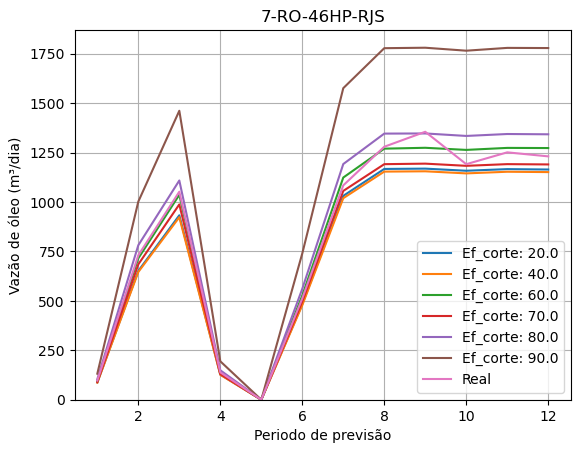

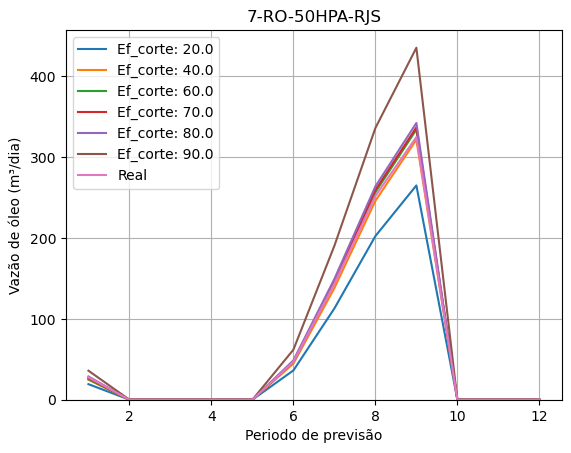

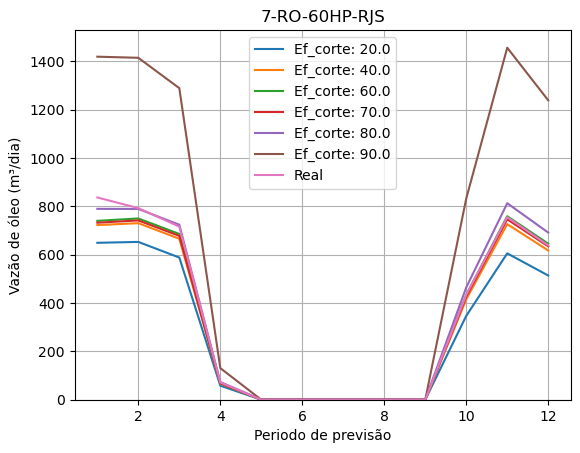

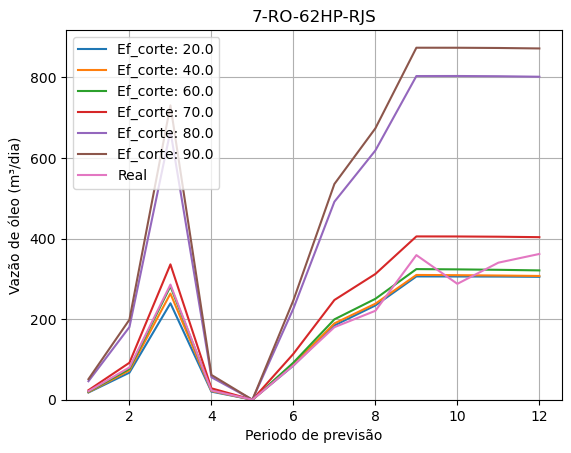

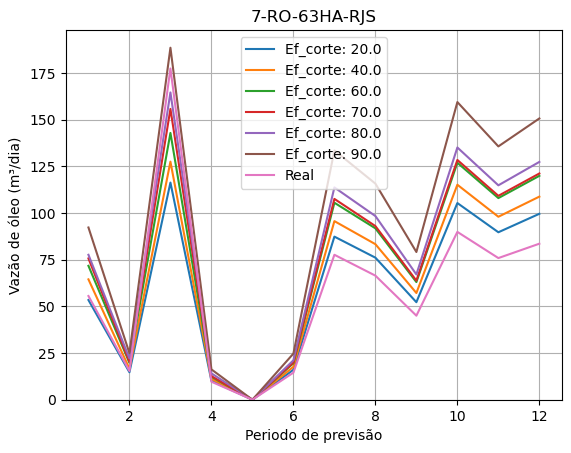

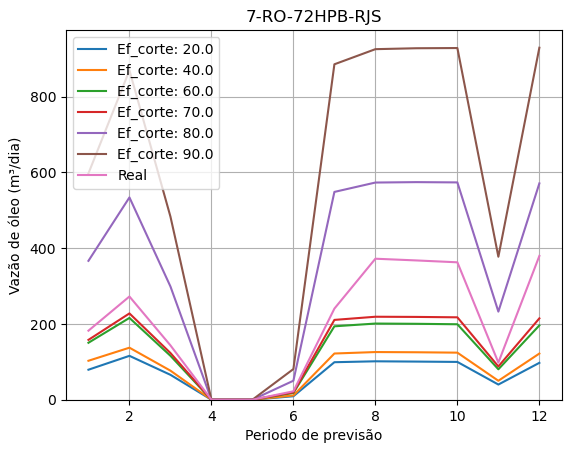

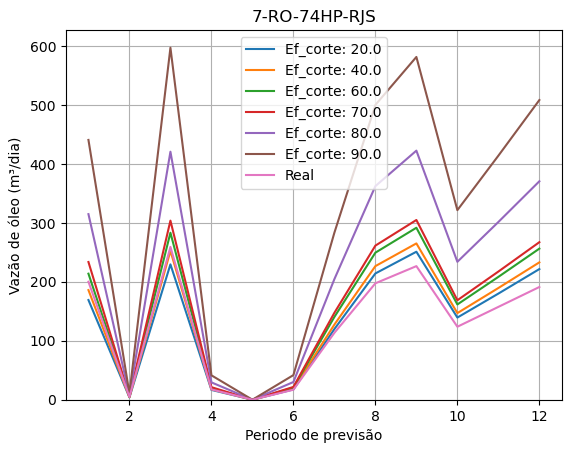

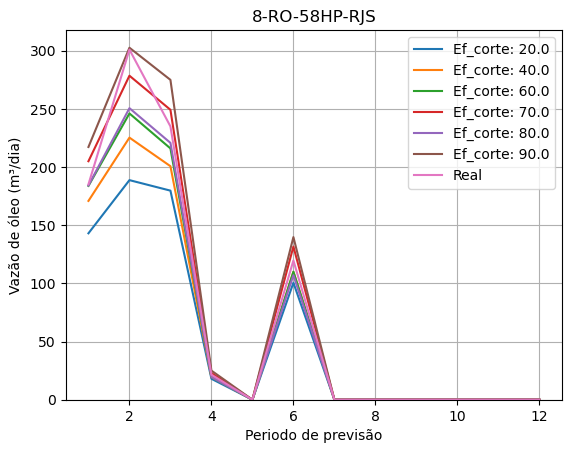

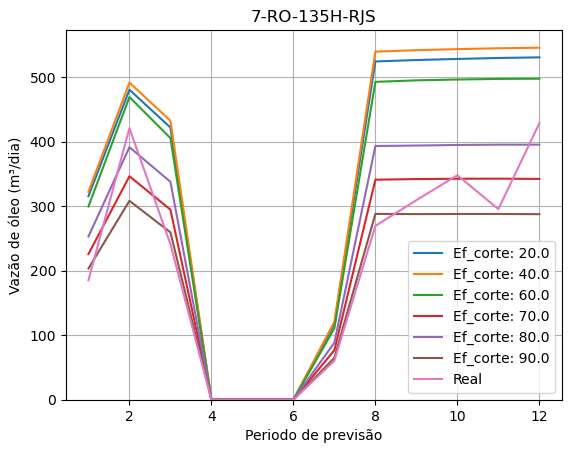

<Figure size 640x480 with 0 Axes>

In [30]:

#df_prev
a=pd.DataFrame(list_previsao)
dados_exportar_test=[]
for i in a[0].unique():
    #plt.figure(figsize=(8,6),dpi=1200)
    b = a[a[0]==i]
    #print(b)
    for index, j in b.iterrows():
        if j[1] == 'prev':
            plt.plot(list(range(1,len(j[2])+1)),j[2],label='Real')
            for k,z in enumerate(j[2]):
                dados_exportar_test.append([i,k,z,'Real'])
        else:
            plt.plot(list(range(1,len(j[2])+1)),j[2],label='Ef_corte: '+str(j[1]*100))
            for k,z in enumerate(j[2]):
                dados_exportar_test.append([i,k,z,str(j[1]*100)])
    plt.ylabel('Vazão de óleo (m³/dia)')
    plt.xlabel('Periodo de previsão')
    plt.ylim(0)
    plt.title(i)
    plt.grid()
    plt.legend()
    plt.show()
    #plt.savefig(i+'.jpeg',dpi=1200)
    plt.clf()

In [32]:
pd.DataFrame(dados_exportar_test,columns=['Poco','periodo','valor','evento']).to_csv('dados_vazao_plotar.txt',sep='\t',decimal=',',index=None)

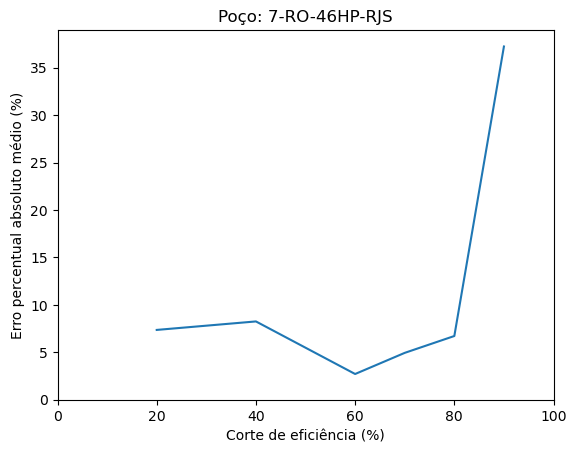

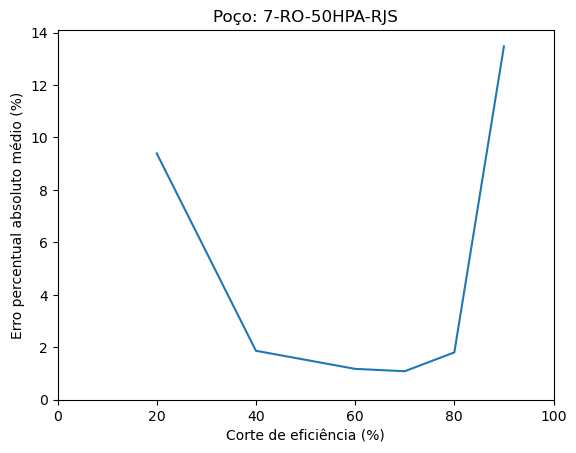

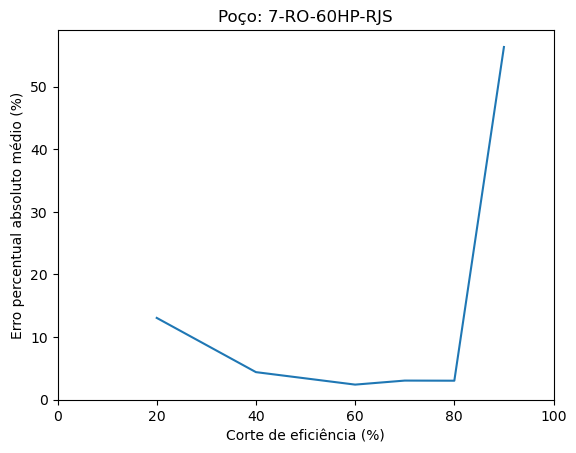

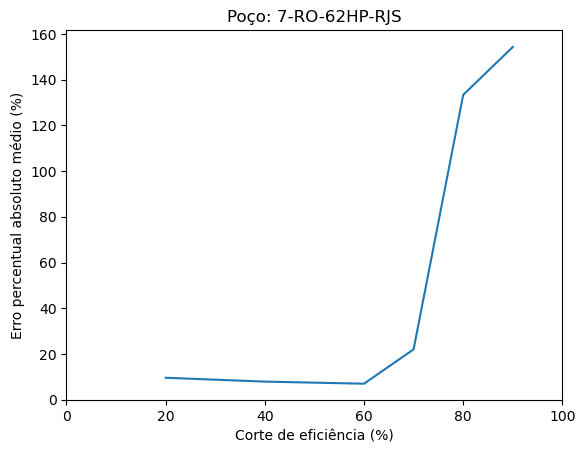

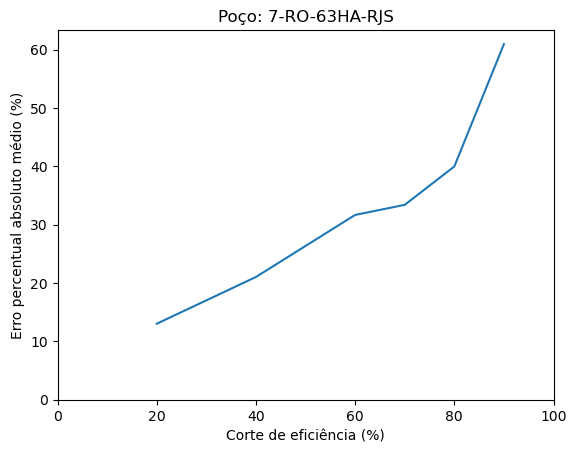

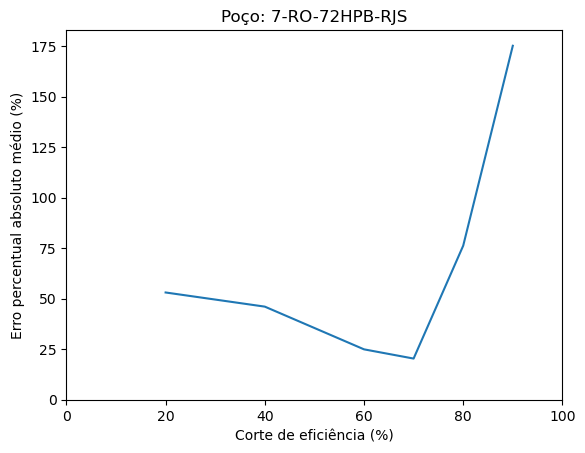

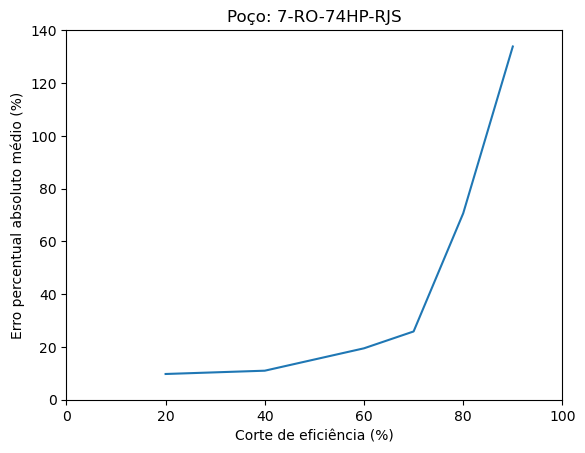

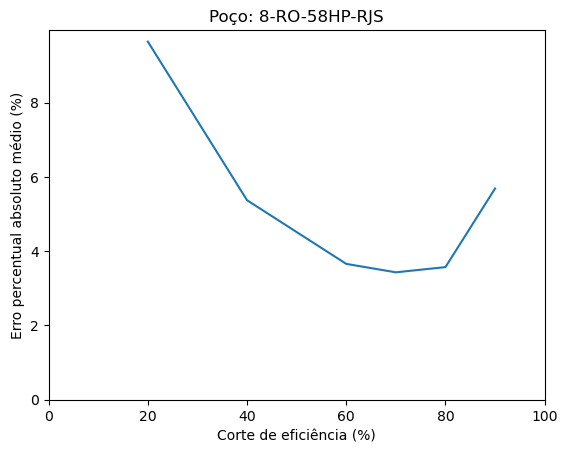

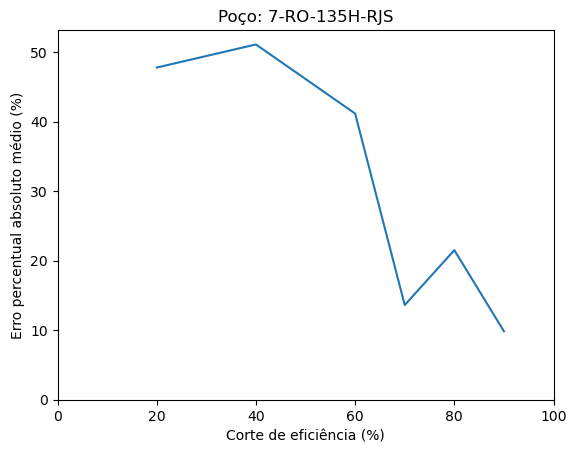

<Figure size 640x480 with 0 Axes>

In [33]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])
a
for i in a.poco.unique():
    #plt.figure(figsize=(8,6),dpi=1200)
    filtro=a.poco==i
    #plt.plot(a[filtro][1],a[filtro][2]/a[filtro][2].max())
    plt.plot(a[filtro].ef*100,a[filtro].mape*100)
    plt.title('Poço: '+i)
    plt.xlabel('Corte de eficiência (%)')
    plt.ylabel('Erro percentual absoluto médio (%)')
    plt.xlim(0,100)
    plt.ylim(0)
    #plt.grid()
    plt.show()
    #plt.savefig(i+'.jpeg',dpi=1200)
    plt.clf()


In [5]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])
pd.pivot_table(a,index='poco',columns='ef',values='mape')
pd.pivot_table(a,index='poco',values='mape',aggfunc='min').reset_index().mape.mean()


0.17248751697914855

In [38]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])
#a.to_csv('lista_erros.txt',sep='\t',decimal=',',index=None)
b=pd.pivot_table(a,index='poco',values='mape',aggfunc='min').reset_index()
b=b.merge(a,how='left', on=['poco','mape']).drop_duplicates(subset='mape')
b
a=pd.DataFrame(list_previsao,columns=['poco','ef','previsao'])
c=a[a.ef=='prev'].copy()
a=a[a.ef!='prev']
b=b.merge(a,on=['poco','ef'],how='left')
b['previsao']=b['previsao'].apply(lambda x: np.array(x))
b.previsao.sum()

c['previsao']=c['previsao'].apply(lambda x: np.array(x))
#pd.DataFrame(c.previsao.sum())



In [39]:
#pd.DataFrame(b.previsao.sum())

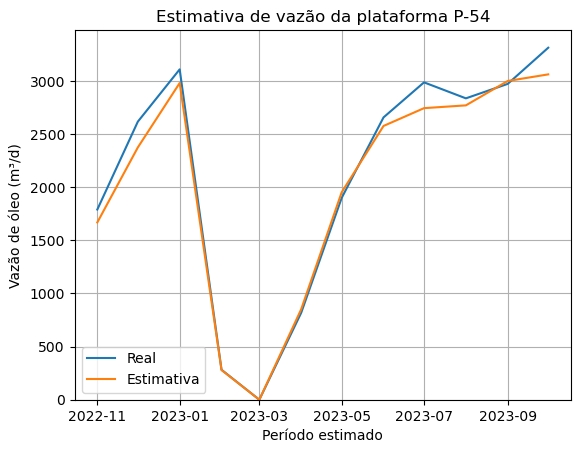

18972.800534891125

<Figure size 640x480 with 0 Axes>

In [43]:
#plt.figure(figsize=(8,6),dpi=1200)
c_real=c.previsao.sum()
b_estimativa=b.previsao.sum()
plt.plot(pd.to_datetime(dfs_pocos[0][1].Data[-12:],format='%Y-%m-%d'),c_real,label='Real')
plt.plot(pd.to_datetime(dfs_pocos[0][1].Data[-12:],format='%Y-%m-%d'),b_estimativa,label='Estimativa')
plt.ylabel('Vazão de óleo (m³/d)')
plt.xlabel('Período estimado')
plt.title('Estimativa de vazão da plataforma P-54')
plt.grid()
plt.ylim(0)
plt.legend()
plt.show()
#plt.savefig('Plataforma.jpeg',dpi=1200)
plt.clf()
mse(c.previsao.sum(),b.previsao.sum())

In [41]:
MAPE(c.previsao.sum(),b.previsao.sum())

0.041649941772078626

In [30]:
a=pd.DataFrame(list_erros,columns=['poco','mape','ef','rmse'])



In [31]:
MAPE([1],[1.2])

0.19999999999999996

In [32]:
df=pd.read_csv('dados_unidos2.txt',sep='\t',decimal=',',encoding='UTF-8')
trocar_colunas={'Período': 'Data', 'Poço ANP':'Poco', 'Petróleo Equivalente (boe/d)':'boed',
           'Óleo (m3/d)':'oleo', 'Gás Natural (mil m3/d)':'gas', 'Água (m3/d)':'agua', 'Dias':'dias',
           'Potencial':'potencial'}
df=df.rename(columns=trocar_colunas)
df['BSW']=df['agua']/(df['agua']+df['oleo']+0.00000001)
#print(df.head)
#df=df[df.agua>0.1]
df['Data']=pd.to_datetime(df['Data'])
df=df[df.Data>='2022-10-01']

unir=pd.pivot_table(a,index='poco',values='mape',aggfunc='min').reset_index()

In [80]:
unir2=pd.pivot_table(df,index='Poco',values='ef',aggfunc='mean').reset_index()
unir2['poco']=unir2['Poco']

In [81]:
unir.merge(unir2,on='poco')

,poco,mape,Poco,ef
0,7-RO-135H-RJS,0.126855,7-RO-135H-RJS,0.702426
1,7-RO-46HP-RJS,0.029468,7-RO-46HP-RJS,0.666539
2,7-RO-50HPA-RJS,0.025007,7-RO-50HPA-RJS,0.190141
3,7-RO-60HP-RJS,0.021205,7-RO-60HP-RJS,0.482966
4,7-RO-62HP-RJS,0.079594,7-RO-62HP-RJS,0.613592
5,7-RO-63HA-RJS,0.071930,7-RO-63HA-RJS,0.491452
6,7-RO-72HPB-RJS,0.149529,7-RO-72HPB-RJS,0.617117
7,7-RO-74HP-RJS,0.095990,7-RO-74HP-RJS,0.261454
8,8-RO-58HP-RJS,0.051347,8-RO-58HP-RJS,0.322748


In [106]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2022-11-01 to 2023-10-01
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              12 non-null     datetime64[ns]
 1   Campo             12 non-null     object        
 2   Poco              12 non-null     object        
 3   boed              12 non-null     float64       
 4   oleo              12 non-null     float64       
 5   gas               12 non-null     float64       
 6   agua              12 non-null     float64       
 7   dias              12 non-null     float64       
 8   potencial         12 non-null     float64       
 9   ef                12 non-null     float64       
 10  Potencial (m³/d)  0 non-null      float64       
 11  BSW               12 non-null     float64       
 12  mes               12 non-null     int64         
 13  tn                12 non-null     float64       
 14  tn_2    

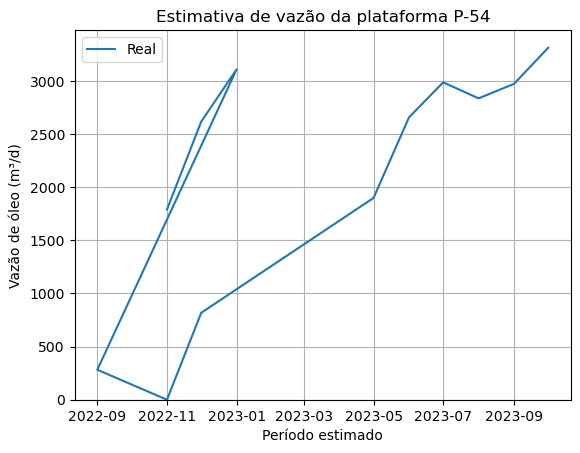

9935.142801823307

<Figure size 640x480 with 0 Axes>

In [103]:
daods_plot=pd.DataFrame({'Data':df_prev.Data.values,'Oleo_e':b_estimativa,'Oleo_r':c_real})

#plt.figure(figsize=(8,6),dpi=1200)

plt.plot(daods_plot.Data,daods_plot.Oleo_r,label='Real')
#plt.plot(b_estimativa,label='Estimativa')
plt.ylabel('Vazão de óleo (m³/d)')
plt.xlabel('Período estimado')
plt.title('Estimativa de vazão da plataforma P-54')
plt.grid()
plt.ylim(0)
plt.legend()
plt.show()
#plt.savefig('Plataforma.jpeg',dpi=1200)
plt.clf()
mse(c.previsao.sum(),b.previsao.sum())

167   2023-01-01
168   2023-02-01
169   2023-03-01
170   2023-04-01
171   2023-05-01
172   2023-06-01
173   2023-07-01
174   2023-08-01
175   2023-09-01
176   2023-10-01
Name: Data, dtype: datetime64[ns]